2025.02.27, Zhang Chao<br>
Show the energy dynamics from 2001 to 2020 at the pixel scale

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
import seaborn as sns
import pymannkendall as mk
import statsmodels.api as sm
import regionmask
import matplotlib.lines as mlines
import sys
import matplotlib as mpl
import os
import scipy
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
import matplotlib.colors as mcolors
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
from utils import getSigFlag, stats_regionratio,stats_regionmean
sys.path.append('/home/climate/chaoz/code/utils/')
from da_utils import get_trend
from plot_utils import plot_settings, uneven_cmap

---Start to load data files---

In [2]:
os.chdir('/home/climate/chaoz/project/03Irr_Ts_CN/processed/')

# Below two input files are produced by './2_process/01_delta_ET_Yr.ipynb'
dLE = xr.open_dataset('delta_LE_PMLv2v017_Yr_CN_2001_2020.nc')
dHE = xr.open_dataset('delta_HE_Yr_CN_2001_2020_PMLv2.nc')
dLE_05d  = xr.open_dataset('delta_LE_Yr_CN_2001_2020_PMLv2_05d.nc')
dHE_05d  = xr.open_dataset('delta_HE_Yr_CN_2001_2020_PMLv2_05d.nc')

dBwr = xr.open_dataset('delta_BowenRatio_Yr_CN_2001_2020_PMLv2.nc')
dBwr2 = xr.open_dataset('delta_BowenRatio2_Yr_CN_2001_2020_PMLv2.nc')

factor = int(0.5 / abs(dLE.lon.diff('lon').mean().item()))

shp_cn = gpd.read_file('../shapefile/ChinaAll.shp')
shp_nanhai = gpd.read_file('../shapefile/Nanhai.shp')
shp_climzone = gpd.read_file('../shapefile/ClimateZone_3.shp')

In [3]:
df_LE = pd.read_csv('regionmean_dLE.csv')
df_HE = pd.read_csv('regionmean_dHE.csv')
df_BR = pd.read_csv('regionmean_dBWR.csv')

Prepare to do necessary calculations

In [4]:
# Calculate the annual and monthly trend of dLST
dLE_05d_trend  = get_trend(dLE_05d, 'LE')
dHE_05d_trend  = get_trend(dHE_05d, 'H')

# Get the regional statistics: proportion of positive and negative slope pixels
stats_LE   = stats_regionratio(dLE_05d_trend,shp_climzone)
stats_HE   = stats_regionratio(dHE_05d_trend,shp_climzone)

Plotting functions

In [7]:
def plot_trend_map(fig, pos, ds, extent,shape_cn,shape_nanhai,levels, mycmap, title):
    lambert_proj = ccrs.LambertConformal(central_longitude=105, central_latitude=35, standard_parallels=(25, 47))
    ax = fig.add_axes(pos, projection=lambert_proj, frame_on=False)
    # Define Lambert Conformal projection (customized for China)

    ds.slope.plot(ax=ax, levels=levels,transform=ccrs.PlateCarree(),#lambert_proj
                     cmap=mycmap, add_colorbar=False, rasterized=True) #vmax=vmax, vmin=vmin,
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    # ax1.add_feature(fea_hpa, edgecolor='k', linewidth=0.8)
    fea_cn = ShapelyFeature(shape_cn.geometry, crs=ccrs.PlateCarree())
    fea_nanhai = ShapelyFeature(shape_nanhai.geometry, crs=ccrs.PlateCarree())
    ax.add_feature(fea_cn,facecolor='none',linewidth=.6)
    ax.add_feature(fea_nanhai,facecolor='none',linewidth=.6)
    
    lons, lats = np.meshgrid(ds.lon, ds.lat)
    area = np.where(ds.p < 0.1)
    ax.scatter(lons[area], lats[area], c='k', alpha=0.5, s=0.5, transform=ccrs.PlateCarree())
    ax.set_title(title)#, x=0.5, y=0.90
    
    # Add the South China Sea map
    hx,vx = 0.0381,0.10
    pos_scs = [ax.get_position().x1-hx,ax.get_position().y0,hx,vx]
    ax_scs = fig.add_axes(pos_scs,projection=lambert_proj,frame_on=True)
    ax_scs.add_feature(fea_cn    ,facecolor='none',linewidth=.6)
    ax_scs.add_feature(fea_nanhai,facecolor='none',linewidth=.6)
    ax_scs.set_extent([107, 120,3,23], crs=ccrs.PlateCarree())
    
    # print(ax_scs.get_position().width,ax_scs.get_position().height)
    return ax


def plot_lat_stats(fig,pos,ds1,ds2,ylim):
    ax = fig.add_axes(pos)
    colors = ['#0a6f67','#955910']
    lat_stats = ds1.quantile([0.25,0.50,0.75], dim='lon')
    lat = lat_stats.lat
    p25 = lat_stats.sel(quantile=0.25)
    p50 = lat_stats.sel(quantile=0.50)
    p75 = lat_stats.sel(quantile=0.75)
    
    # Fill the region between the 25th and 75th percentiles
    ax.fill_betweenx(lat,p25,p75,color=colors[0],alpha=0.3)
    # Plot the median (50th percentile) as a solid line
    ax.plot(p50,lat,color=colors[0],linewidth=1.2)
    
    lat_stats = ds2.quantile([0.25,0.50,0.75], dim='lon')
    lat = lat_stats.lat
    p25 = lat_stats.sel(quantile=0.25)
    p50 = lat_stats.sel(quantile=0.50)
    p75 = lat_stats.sel(quantile=0.75)
    
    # Fill the region between the 25th and 75th percentiles
    ax.fill_betweenx(lat,p25,p75,color=colors[1],alpha=0.3)
    # Plot the median (50th percentile) as a solid line
    ax.plot(p50,lat,color=colors[1],linewidth=1.2)
    
    ax.axvline(0,0,1,color='k',linewidth=1,linestyle='--')
    # ax.text(0.1,0.98,'Day'  ,transform = ax.transAxes,fontsize=12,color=colors[0])
    # ax.text(0.1,0.92,'Night',transform = ax.transAxes,fontsize=12,color=colors[1])
    ax.yaxis.tick_right()
    ax.set_ylim(ylim)
    ax.set_xlim([-0.3,0.3])
    ax.set_xticks([-0.20,0,0.20],[-2,0,2], fontsize=12)
    ax.set_yticks([20,30,40,50],['20N','30N','40N','50N'])
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Create custom legend handles
    handles = [
        mlines.Line2D([], [], color=colors[0], linestyle='-', label='$\Delta$LE'),
        mlines.Line2D([], [], color=colors[1], linestyle='-', label='$\Delta$HE'),
    ]
    
    ax.legend(handles=handles, ncol=1, loc='upper right',frameon=False,
                  handlelength=1.0, handleheight=0.5, columnspacing = 1,handletextpad=0.5,
                  bbox_to_anchor=(1.1, 1.05))
    
    return ax


def plot_bar_regionstats(fig,pos,stats):
    ax = fig.add_axes(pos)
    ax.patch.set_alpha(0)
    cn,arid,semi,humid = stats[0],stats[1],stats[2],stats[3]
    colors = ['#1a8076','#be7d27','#BFBFBF']
    width = 1.3
    x = [1, 3, 5]
    ax.bar(x, [ arid[0], semi[0], humid[0]], width, color=colors[2])
    ax.bar(x, [ arid[2], semi[2], humid[2]], width, color=colors[0])
    ax.bar(x, [-arid[1],-semi[1],-humid[1]], width, color=colors[2])
    ax.bar(x, [-arid[3],-semi[3],-humid[3]], width, color=colors[1])
    # print(p1[0], p2[0],p3[0])
    ax.axhline(y=0.0, c="k", ls="-", lw=1)
    ax.set_xticks(x,['Arid','Semi','Humid'],fontsize=10,rotation=30)
    ax.text(0.08,0.75,'%.0f%%' % cn[2], c=colors[0], transform=ax.transAxes)
    ax.text(0.08,0.05,'%.0f%%' % cn[3], c=colors[1], transform=ax.transAxes)
    ax.set_ylim(-35,35)

    ax.set_yticks([-25,0,25], ['25','0','25'],fontsize=10)
    ax.set_ylabel('Frequency [%]',fontsize=10)
    
    ax.tick_params(axis='x', bottom=True,length=0)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['right'].set_visible(False)
    
    return ax


def plot_trend(fig,axpos,y,number,colori,xlabelFlag,title,yticks):
    ax=fig.add_axes(axpos)
    colors = ['#1a8076','#be7d27','k','gray']
    x = range(1, len(y)+1)

    ax.plot(x, y, c=colors[colori], )
    parameter = np.polyfit(x, y, 1)
    f = np.poly1d(parameter)
    r, sig = scipy.stats.pearsonr(x, y)
    ax.plot(x, f(x), ls='--', c=colors[colori])
    # print('f(2001)=',f(1))
    ax.text(-0.15,1.1,number,transform=ax.transAxes,c='k',
             weight='bold',fontsize=18)#,style='italic'
    ax.text(0.10,0.95, "slope = %.2f$^{%s}$" %
             (parameter[0]*10, getSigFlag(sig)),
             transform=ax.transAxes, c= 'k',fontsize=12)
    
    ax.set_xlim(0,21)
    # ax.set_ylim(ylim)
    if xlabelFlag == True:
        ax.set_xticks([5,15], [2005,2015])
        ax.set_xlabel('Year')
    else:
        ax.set_xticks([5,15], [])

    ax.set_yticks(yticks)
    ax.set_title(title,pad=25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax


# Function to add color bar for the main maps
def add_colorbar_map(fig, pos,mycmap, mynorm, levels,ticklabels):
    ax = fig.add_axes(pos)
    cb1 = mpl.colorbar.ColorbarBase(ax=ax, cmap=mycmap, norm=mynorm,
                                    orientation='vertical',
                                    ticks=levels,extend='neither')
    ax.set_yticklabels(ticklabels)
    ax.set_ylabel('Slope [K/decade]',labelpad=5)
    ax.tick_params(axis='y',right=True,length=0)


# Function to add color bar for the main maps
def add_colorbar_horizontal(ax, mycmap, mynorm, levels,ticklabels):
    cb1 = mpl.colorbar.ColorbarBase(ax=ax, cmap=mycmap, norm=mynorm,
                                    orientation='horizontal',
                                    ticks=levels,extend='neither') 
    ax.set_xticklabels(ticklabels)
    ax.text(1.17, 0.1, 'Slope [W/m$^{2}$/decade]', ha='center', #va='center', 
            transform=ax.transAxes,fontsize=12)

Plot figures

0.4 0.31567579279956404


/home/climate/chaoz/.conda/envs/geo_env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


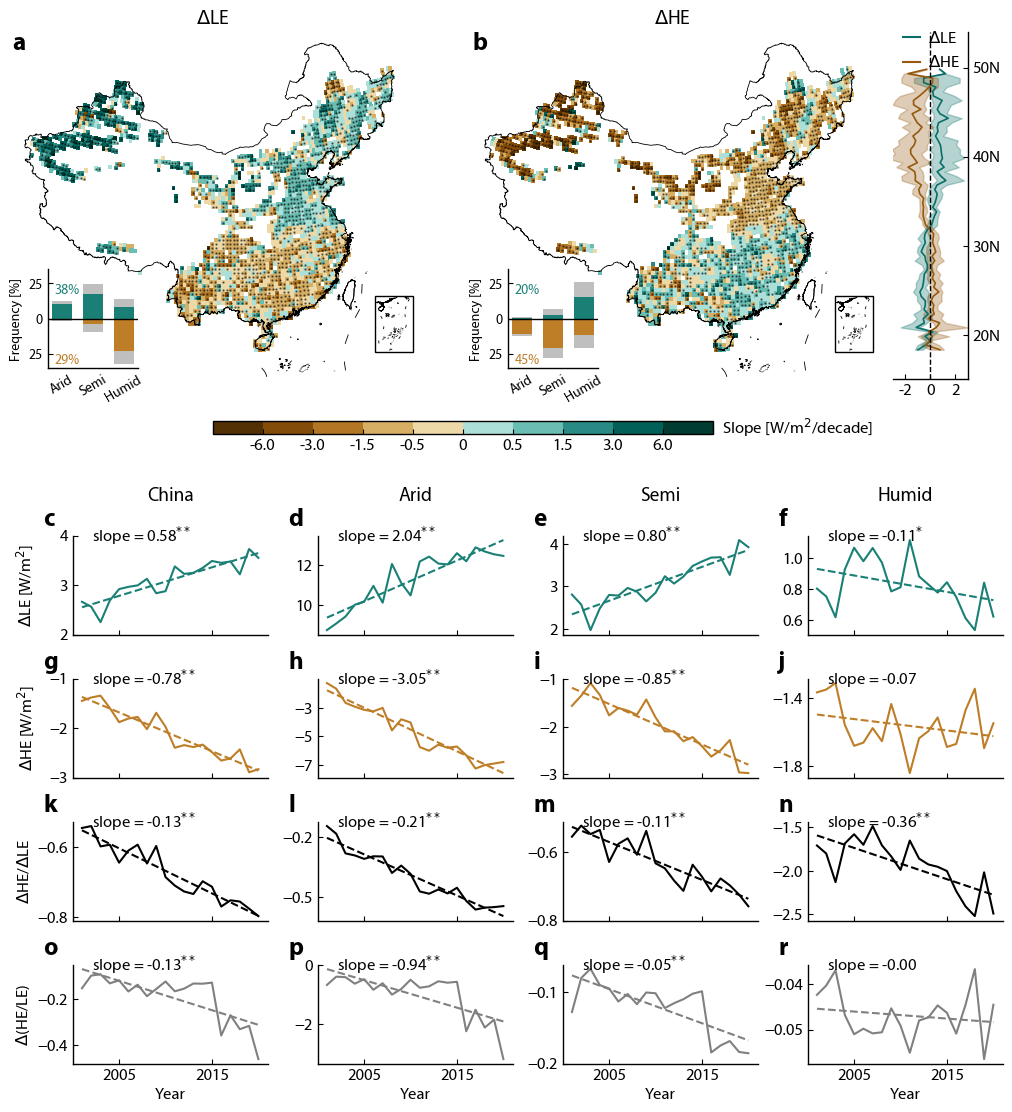

In [ ]:
colors1 = plt.cm.BrBG(np.linspace(0.00, 0.40, 128))  # 128* seismic bwr PRGn
colors2 = plt.cm.BrBG(np.linspace(0.60, 1.00, 128))  # 128* seismic
colors = np.vstack((colors1, colors2))
mycmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
plevel = np.array([0,0.05,0.15,0.30,0.60,2])
nlevel = -1 * plevel[1:]
levels1 = np.concatenate([nlevel[::-1], plevel])
cmap1, norm1 = uneven_cmap(levels1, cmap=mycmap)#RdYlBu_r 'BrBG'


fig = plt.figure(figsize=(10,11))
plot_settings()
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

x0,y0 = 0.07,0.04
xi,yi = 0.05,0.04
hx1,vx1 = (1-x0-3*xi)/4,0.09

pos11 = [x0+(hx1+xi)*0, y0+(vx1+yi)*0, hx1, vx1]
pos12 = [x0+(hx1+xi)*1, y0+(vx1+yi)*0, hx1, vx1]
pos13 = [x0+(hx1+xi)*2, y0+(vx1+yi)*0, hx1, vx1]
pos14 = [x0+(hx1+xi)*3, y0+(vx1+yi)*0, hx1, vx1]

pos21 = [x0+(hx1+xi)*0, y0+(vx1+yi)*1, hx1, vx1]
pos22 = [x0+(hx1+xi)*1, y0+(vx1+yi)*1, hx1, vx1]
pos23 = [x0+(hx1+xi)*2, y0+(vx1+yi)*1, hx1, vx1]
pos24 = [x0+(hx1+xi)*3, y0+(vx1+yi)*1, hx1, vx1]

pos31 = [x0+(hx1+xi)*0, y0+(vx1+yi)*2, hx1, vx1]
pos32 = [x0+(hx1+xi)*1, y0+(vx1+yi)*2, hx1, vx1]
pos33 = [x0+(hx1+xi)*2, y0+(vx1+yi)*2, hx1, vx1]
pos34 = [x0+(hx1+xi)*3, y0+(vx1+yi)*2, hx1, vx1]

pos41 = [x0+(hx1+xi)*0, y0+(vx1+yi)*3, hx1, vx1]
pos42 = [x0+(hx1+xi)*1, y0+(vx1+yi)*3, hx1, vx1]
pos43 = [x0+(hx1+xi)*2, y0+(vx1+yi)*3, hx1, vx1]
pos44 = [x0+(hx1+xi)*3, y0+(vx1+yi)*3, hx1, vx1]

ax11 = plot_trend(fig,pos11,                  df_BR['China']     , 'o', 3, True,'', [-0.4,-0.2])
ax12 = plot_trend(fig,pos12,                  df_BR['Arid']      , 'p', 3, True,'', [-2,0])
ax13 = plot_trend(fig,pos13,                  df_BR['Semi']      , 'q', 3, True,'', [-0.2,-0.1])
ax14 = plot_trend(fig,pos14,                  df_BR['Humid']     , 'r', 3, True,'', [-0.05,-0.04])

ax21 = plot_trend(fig,pos21, df_HE['China'] / df_LE['China']     , 'k', 2, '','', [-0.8,-0.6])
ax22 = plot_trend(fig,pos22, df_HE['Arid']  / df_LE['Arid']      , 'l', 2, '','', [-0.5,-0.2])
ax23 = plot_trend(fig,pos23, df_HE['Semi']  / df_LE['Semi']      , 'm', 2, '','', [-0.8,-0.6])
ax24 = plot_trend(fig,pos24, df_HE['Humid'] / df_LE['Humid']     , 'n', 2, '','', [-2.5,-2.0,-1.5])

ax31 = plot_trend(fig,pos31,                  df_HE['China']     , 'g', 1, '','', [-3,-2,-1])
ax32 = plot_trend(fig,pos32,                  df_HE['Arid']      , 'h', 1, '','', [-7,-5,-3])
ax33 = plot_trend(fig,pos33,                  df_HE['Semi']      , 'i', 1, '','', [-3,-2,-1])
ax34 = plot_trend(fig,pos34,                  df_HE['Humid']     , 'j', 1, '','', [-1.8,-1.4])

ax41 = plot_trend(fig,pos41,                  df_LE['China']     , 'c', 0, '','China', [2,3,4])
ax42 = plot_trend(fig,pos42,                  df_LE['Arid']      , 'd', 0, '','Arid' , [10,12])
ax43 = plot_trend(fig,pos43,                  df_LE['Semi']      , 'e', 0, '','Semi' , [2,3,4])
ax44 = plot_trend(fig,pos44,                  df_LE['Humid']     , 'f', 0, '','Humid', [0.6,0.8,1.0])

pos51 = [0.01, y0+(vx1+yi)*4+0.06, 0.4,0.4]
pos52 = [0.47, y0+(vx1+yi)*4+0.06, 0.4,0.4]

extent = [80, 127,15,54]

ax51 = plot_trend_map(fig, pos51, dLE_05d_trend, extent,shp_cn,shp_nanhai,levels1, cmap1, '$\Delta$LE')
ax52 = plot_trend_map(fig, pos52, dHE_05d_trend, extent,shp_cn,shp_nanhai,levels1, cmap1, '$\Delta$HE')


print(ax51.get_position().width, ax51.get_position().height)

# Plot the latitudinal statistics on the right
# pos51_r = [ax51.get_position().x1+0.01,ax51.get_position().y0,0.06,ax51.get_position().height]
pos52_r = [ax52.get_position().x1+0.02,ax52.get_position().y0,0.075,ax52.get_position().height]

# ax51_r = plot_lat_stats(fig,pos51_r,dLE_05d_trend.slope,[extent[2],extent[3]])
ax52_r = plot_lat_stats(fig,pos52_r,dLE_05d_trend.slope,dHE_05d_trend.slope,[extent[2],extent[3]])

# Plot the regional statistics at the left-bottom corner
pos51_lb = [ax51.get_position().x0+0.035,ax51.get_position().y0+0.01,0.09,0.09]
pos52_lb = [ax52.get_position().x0+0.035,ax52.get_position().y0+0.01,0.09,0.09]
ax51_lb  = plot_bar_regionstats(fig,pos51_lb,stats_LE)
ax52_lb  = plot_bar_regionstats(fig,pos52_lb,stats_HE)

pos_cbar52 = [ax51.get_position().x1-0.2, ax51.get_position().y0-0.05,
             0.5, 0.012]
ticklabels = ['','-6.0','-3.0','-1.5','-0.5','0','0.5','1.5','3.0','6.0','']
add_colorbar_horizontal(fig.add_axes(pos_cbar52),cmap1, norm1, levels1,ticklabels)

ax51.text(-0.00, 0.95,'a',weight='bold',fontsize=18,transform=ax51.transAxes)
ax52.text(-0.00, 0.95,'b',weight='bold',fontsize=18,transform=ax52.transAxes)

ax11.set_ylabel('$\Delta$(HE/LE)')
ax21.set_ylabel('$\Delta$HE/$\Delta$LE')
ax31.set_ylabel('$\Delta$HE [W/m$^{2}$]',labelpad=9)
ax41.set_ylabel('$\Delta$LE [W/m$^{2}$]',labelpad=17)


# plt.savefig('../figures/Figure_03.png',dpi=300)
plt.savefig('../figures/Figure_03.pdf')